In [1]:
using DrWatson
@quickactivate projectdir()

In [2]:
include(srcdir("rdpg.jl"))
import Main.rdpg
using PersistenceDiagrams, Pipe, Plots, ProgressMeter, Random, Ripserer, Statistics, StatsBase
using Distributions, LinearAlgebra, UMAP

In [70]:
function scale_embeddings(X)
    return StatsBase.standardize(ZScoreTransform, X, dims=1)
end

function diagram(X; dim_max)
    dgm = ripserer(X |> Alpha, dim_max=dim_max)
    [replace(x -> death(x) == Inf ? PersistenceInterval(birth(x), threshold(d)) : x, d) for d in dgm]
end

function bottleneck_distance(Dx, Dy; order=nothing, p=Inf)
    order = isnothing(order) ? 0 : order
    dx, dy = Dx[1+order], Dy[1+order]
    m = max(0, min(length.((dx, dy))...) .- 2)
    dx = dx[end-m:end]
    dy = dy[end-m:end]
    return norm(map((x, y) -> (x .- y) .|> abs |> maximum, dx, dy), p)
end

function subsample(X, a=1)
    sample(X |> rdpg.m2t, round(Int, size(X, 1)^a), replace=false)
end

function generate_graph(n; k=2, r=0.1, p=0.2)
    Z = rand(1:k, n)
    f = (x, y) -> r + p * (x == y)
    return rdpg.Adjacency(f, Z)
end


function sim(n, d, e, order, p=2)
    ϵ = e

    A = generate_graph(n)
    X, _, _ = rdpg.spectralEmbed(A, d=d)
    DX = diagram(X |> subsample, dim_max=order)
    plt1 = @pipe X |> rdpg.m2t |> scatter(_, label="1", ratio=1, ma=0.1, msw=0)


    X_norm = scale_embeddings(X)
    DX_norm = diagram(X_norm |> subsample, dim_max=order)
    plt2 = @pipe X_norm |> rdpg.m2t |> scatter(_, label="1", ratio=1, ma=0.1, msw=0)


    A1 = rdpg.edgeFlip(A, ϵ=ϵ)
    X1, _ = rdpg.spectralEmbed(A1, d=d)
    X1_norm = scale_embeddings(X1)
    D1_norm = diagram(X1_norm |> subsample, dim_max=order)
    plt2 = @pipe X1 |> rdpg.m2t |> scatter(plt2, _, ratio=1, ma=0.5, msw=0)
    plt2 = @pipe X1_norm |> rdpg.m2t |> scatter(plt2, _, ratio=1, ma=0.1, msw=0)


    A2 = (A1 .- rdpg.τ(ϵ)^2) ./ rdpg.σ(ϵ)^2
    X2, _ = rdpg.spectralEmbed(A2, d=d)
    D2 = diagram(X2 |> subsample, dim_max=order)
    plt1 = @pipe X2 |> rdpg.m2t |> scatter(plt1, _, ratio=1, ma=0.5, msw=0)

    println((:d_we, bottleneck_distance(DX, D2, p=p), :d_ne, bottleneck_distance(DX_norm, D1_norm, p=p)))

    return (bottleneck_distance(DX, D2, p=p), bottleneck_distance(DX_norm, D1_norm, p=p)), (plot(plt1, plt2), plot(plot(DX), plot(D2), title="we"), plot(plot(DX_norm), plot(D1_norm), title="ne"))
end

sim (generic function with 2 methods)

In [138]:
N = [100, 1000, 10000, 50000]
repeats = 5
eps = 4

4

In [ ]:
mn = zeros(size(N, 1), 2)
md = zeros(size(N, 1), 2)
sd = zeros(size(N, 1), 2)

for (n, i) in zip(N, eachindex(N))
    Random.seed!(2022)
    println("\n\n\nStarting with n=$n")
    tmp = [sim(n, 2, eps, 1)[1] for _ in 1:repeats]
    mn[i, :] = @pipe tmp |> rdpg.t2m |> mean(_, dims=1)
    md[i, :] = @pipe tmp |> rdpg.t2m |> median(_, dims=1)
    sd[i, :] = @pipe tmp |> rdpg.t2m |> std(_ .* 0.5, dims=1)
end




Starting with n=100
(:d_we, 0.033999691068430954, :d_ne, 2.365992411404341e-10)
(:d_we, 0.038558760514183665, :d_ne, 0.05955606106040017)
(:d_we, 0.042308989661653654, :d_ne, 0.19592271238183298)
(:d_we, 0.03303276734723419, :d_ne, 1.1185516209268821e-10)
(:d_we, 0.03256606578233948, :d_ne, 0.13391772705245755)



Starting with n=1000
(:d_we, 0.027482530806545273, :d_ne, 0.030860312698206674)
(:d_we, 0.026351979814511282, :d_ne, 0.0733279350986674)
(:d_we, 0.026909910607999646, :d_ne, 0.021340959494020897)
(:d_we, 0.026482940712104316, :d_ne, 0.03435979458811461)
(:d_we, 0.025158430382143153, :d_ne, 0.030170046908544072)



Starting with n=10000
(:d_we, 0.026666102690262292, :d_ne, 0.08550510469567162)
(:d_we, 0.026035047183215105, :d_ne, 0.0682089118435482)
(:d_we, 0.02560845552160762, :d_ne, 0.06202815589821539)
(:d_we, 0.025400072108373032, :d_ne, 0.09236503632427814)
(:d_we, 0.024500592182101294, :d_ne, 0.08167548312098413)



Starting with n=50000
(

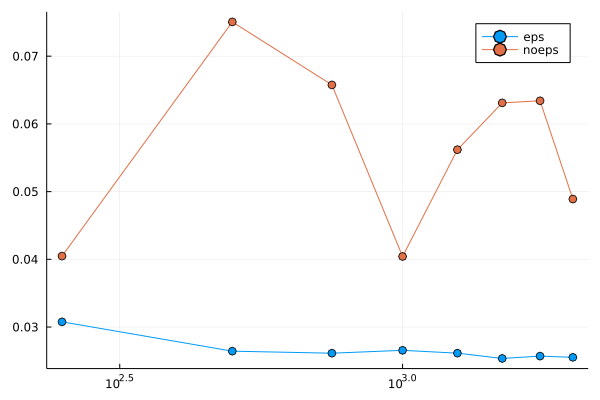

In [136]:
plot(N, mn[:, 1], m=:o, label="eps", xscale=:log10)
plot!(N, mn[:, 2], m=:o, label="noeps", xscale=:log10)